# XGBoost-GP Tutorial





## Install the necessary libraries to the Colab machine

In [0]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install gpytorch torch xgboost pyproj

In [0]:
import gpytorch
import torch
import pickle
import joblib
import pyproj
import numpy as np
from torch import Tensor
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import xgboost as xgb
from sklearn.linear_model import LinearRegression

## Authenticate and mount google drive to the machine

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/sweden/spring_barley_data.csv")
data = data[(data["year"]>=2000) & (data["month"] < 11)
           & (data["month"] >= 2)]

In [0]:
data.columns

Index(['Unnamed: 0', 'name', 'year', 'month', 'ndvi_mean', 'gvi_mean',
       'gpp_mean',
       'Minimum_temperature_height_above_ground_6_Hour_Interval_mean',
       'Maximum_temperature_height_above_ground_6_Hour_Interval_mean',
       'Pressure_surface_mean', 'total_precipitation',
       'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean',
       'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean',
       'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean',
       'longitude', 'latitude', 'yield'],
      dtype='object')

In [0]:
data.head()

,Unnamed: 0,name,year,month,ndvi_mean,gvi_mean,gpp_mean,Minimum_temperature_height_above_ground_6_Hour_Interval_mean,Maximum_temperature_height_above_ground_6_Hour_Interval_mean,Pressure_surface_mean,total_precipitation,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean,longitude,latitude,yield
0,2,Örebro,2000,2,0.103730,0.086546,0.000616,273.001723,274.672413,99559.310345,53.370621,0.304558,0.240992,0.289151,14.993965,59.371844,3370
1,3,Örebro,2000,3,0.180292,0.183555,0.002639,272.843146,276.303226,99956.250000,38.273807,0.246198,0.245012,0.252212,14.993965,59.371844,3370
2,4,Örebro,2000,4,0.240171,0.272447,0.013009,278.268333,282.076667,100101.291667,89.985600,0.229600,0.241322,0.231647,14.993965,59.371844,3370
3,5,Örebro,2000,5,0.392900,0.357919,0.040423,283.476612,288.015726,100473.709677,69.889936,0.184732,0.225585,0.214109,14.993965,59.371844,3370
4,6,Örebro,2000,6,0.631815,0.536551,0.057179,285.002500,289.177916,100263.291667,72.748800,0.214135,0.203277,0.214743,14.993965,59.371844,3370


## Add in prev crop yield


In [0]:
data["prev"] = 0
for year in range(2000, 2018):
    data.loc[data["year"]==year+1, "prev"] = data.loc[data["year"]==year, "yield"].values

In [0]:
data.head()

,Unnamed: 0,name,year,month,ndvi_mean,gvi_mean,gpp_mean,Minimum_temperature_height_above_ground_6_Hour_Interval_mean,Maximum_temperature_height_above_ground_6_Hour_Interval_mean,Pressure_surface_mean,total_precipitation,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean,longitude,latitude,yield,prev
0,2,Örebro,2000,2,0.103730,0.086546,0.000616,273.001723,274.672413,99559.310345,53.370621,0.304558,0.240992,0.289151,14.993965,59.371844,3370,0
1,3,Örebro,2000,3,0.180292,0.183555,0.002639,272.843146,276.303226,99956.250000,38.273807,0.246198,0.245012,0.252212,14.993965,59.371844,3370,0
2,4,Örebro,2000,4,0.240171,0.272447,0.013009,278.268333,282.076667,100101.291667,89.985600,0.229600,0.241322,0.231647,14.993965,59.371844,3370,0
3,5,Örebro,2000,5,0.392900,0.357919,0.040423,283.476612,288.015726,100473.709677,69.889936,0.184732,0.225585,0.214109,14.993965,59.371844,3370,0
4,6,Örebro,2000,6,0.631815,0.536551,0.057179,285.002500,289.177916,100263.291667,72.748800,0.214135,0.203277,0.214743,14.993965,59.371844,3370,0


In [0]:
# state variable names needed 
variables = ['name', 'year', 'month', 'ndvi_mean', 'gvi_mean', 'gpp_mean',
           'Minimum_temperature_height_above_ground_6_Hour_Interval_mean',
           'Maximum_temperature_height_above_ground_6_Hour_Interval_mean',
           'Pressure_surface_mean', 'total_precipitation',
           'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean',
           'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean',
           'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean',
           'longitude', 'latitude', "prev", 'yield']

xgb_variables = ['longitude', 'latitude', "year", 'ndvi_mean', 'gvi_mean', 'gpp_mean',
               'Minimum_temperature_height_above_ground_6_Hour_Interval_mean',
               'Maximum_temperature_height_above_ground_6_Hour_Interval_mean',
               'Pressure_surface_mean', 'total_precipitation',
               'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean',
               'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean',
               'Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean',
               "prev"]


In [0]:
data = data[variables]
data = data[data["year"]!=2000]

In [0]:
data = data.dropna()

In [0]:
data

,name,year,month,ndvi_mean,gvi_mean,gpp_mean,Minimum_temperature_height_above_ground_6_Hour_Interval_mean,Maximum_temperature_height_above_ground_6_Hour_Interval_mean,Pressure_surface_mean,total_precipitation,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean,longitude,latitude,prev,yield
11,Örebro,2001,2,0.100606,0.040110,3.656664e-04,267.725000,270.002233,100358.794643,54.351000,0.314833,0.244902,0.416961,14.993965,59.371844,3370,3720
12,Örebro,2001,3,0.139528,0.127624,1.206043e-03,270.349597,272.943549,99930.241935,55.268129,0.311803,0.230483,0.414962,14.993965,59.371844,3370,3720
13,Örebro,2001,4,0.168760,0.173830,4.654468e-03,276.435000,279.438750,99975.250000,83.473200,0.256849,0.238570,0.325112,14.993965,59.371844,3370,3720
14,Örebro,2001,5,0.378842,0.367251,2.467853e-02,281.572581,285.945161,100431.370968,62.699225,0.227656,0.275121,0.243990,14.993965,59.371844,3370,3720
15,Örebro,2001,6,0.535522,0.471227,4.786231e-02,285.396666,289.546249,100050.916667,60.739200,0.205845,0.238126,0.214878,14.993965,59.371844,3370,3720
16,Örebro,2001,7,0.628508,0.543974,5.816734e-02,288.926209,293.459275,100246.491935,109.647871,0.220887,0.202556,0.214878,14.993965,59.371844,3370,3720
17,Örebro,2001,8,0.475702,0.417329,2.994063e-02,287.065323,290.518146,100248.750000,101.443355,0.217945,0.186614,0.213432,14.993965,59.371844,3370,3720
18,Örebro,2001,9,0.398565,0.341731,9.542162e-03,282.972499,285.157916,100029.791667,131.706000,0.250364,0.188123,0.241804,14.993965,59.371844,3370,3720
19,Örebro,2001,10,0.244756,0.178044,5.086487e-03,281.388710,283.433871,100135.524194,99.708387,0.241893,0.205446,0.239051,14.993965,59.371844,3370,3720
22,Örebro,2002,2,0.072356,0.058553,6.775871e-04,273.920535,275.444196,98663.660714,105.774429,0.307971,0.269831,0.279129,14.993965,59.371844,3720,4410


## Define the Classes and functions needed for the model

In [0]:
class XGBoost_gp(gpytorch.models.ExactGP):
    """XGB-GP

    input:

        train_x: training features: Nxp dimensions
        train_y: training labels: Nx1 dimensions
        likelihood: Specify the likelihood function - from gpytorch classes
    """
    def __init__(self, train_x, train_y, likelihood, xgb_regression):
        """
        Define your mean functions and kernel here
        """
        super(XGBoost_gp, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.xgb_mean = xgb_regression
        self.covar_spatial = gpytorch.kernels.RBFKernel()
        self.covar_time = gpytorch.kernels.RBFKernel()
        self.covar_remote = gpytorch.kernels.MaternKernel()
        
    
    def forward(self, x):
        """forward pass of GP model

        """
        spatial = x.narrow(1,0,2)
        year = x.narrow(1,2,1)
        remote = x.narrow(1,3,10)
        
        # compute mean
        x_pandas = pd.DataFrame(x.cpu().numpy(), columns = xgb_variables)
        data_x = xgb.DMatrix(data=x_pandas)
        predictions = self.xgb_mean.predict(data_x)
        mean = self.mean_module(x).view(-1) + Tensor(predictions).cuda()

        #compute covariances
        covar_time = self.covar_time(year)
        covar_spatial = self.covar_spatial(spatial)
        covar_remote = self.covar_remote(remote)
        covariance = covar_time*covar_spatial + covar_remote

        return gpytorch.distributions.MultivariateNormal(mean, covariance)

class Simple_GP(gpytorch.models.ExactGP):
    """Simple GP

    input:

        train_x: training features: Nxp dimensions
        train_y: training labels: Nx1 dimensions
        likelihood: Specify the likelihood function - from gpytorch classes
    """
    def __init__(self, train_x, train_y, likelihood):
        super(Simple_GP, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_spatial = gpytorch.kernels.RBFKernel()
        self.covar_time = gpytorch.kernels.RBFKernel()
        self.covar_remote = gpytorch.kernels.MaternKernel()
    
    def forward(self, x):
        """forward pass of GP model

        """
        spatial = x.narrow(1,0,2)
        year = x.narrow(1,2,1)
        remote = x.narrow(1,3,10)
        
        # compute mean
        mean = self.mean_module(x).view(-1)
        
        #compute covariances
        covar_time = self.covar_time(year)
        covar_spatial = self.covar_spatial(spatial)
        covar_remote = self.covar_remote(remote)
        
        covariance = covar_time*covar_spatial + covar_remote

        return gpytorch.distributions.MultivariateNormal(mean, covariance)
    
def train_model(train_x, train_y, model, likelihood, epochs = 50):
    """training procedure

    input:

        model: model object
        likelihood: likelihood object
        epochs: number of training epochs

    output:

        model: trained posterior model

    """
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    if torch.cuda.is_available():
        likelihood = likelihood.cuda()
        model = model.cuda()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    marginal_likelihood = []

    for i in range(epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        marginal_likelihood.append(loss.item())
        
        if (i+1) % 50 ==0:
            print("Iter {}/{} - Loss: {}".format(
                i + 1, epochs, loss.item()
            ))

        optimizer.step()

    return model, marginal_likelihood


def predict(test_x, model, likelihood):
    """compute posterior predictive mean and variance

    input:

        test_x: covariates of test in matrix form
        model: GP model object
        likelihood: likelihood object

    output:

        posterior_pred: return posterior prediction objected

    """

    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    # gpytorch.settings.fast_pred_var() for LOVE prediction
    with torch.no_grad():
        posterior_pred = likelihood(model(test_x))

    return posterior_pred
    



## Let's train and save our models

In [0]:
epochs = 100

# train models for month 2 to month 10
for month in range(2,11):
    
    print("Month {}".format(month))
    # train xgboost model
    data_train = data[(data["month"] == month) & (data["year"] <= 2016)]
    train_x = data_train[xgb_variables]
    train_y = data_train["yield"]
    
    # linear regression
    lm = LinearRegression().fit(train_x, train_y)

    print("Begin XGBoost training")
    data_dmatrix = xgb.DMatrix(data=train_x,label=train_y)
    params = {"objective":"reg:squarederror",'learning_rate': 0.1,
                'max_depth': 5}
    xgb_regression = xgb.train(params, dtrain=data_dmatrix, num_boost_round=1000)
    print("End XGBoost Training")
    # define GP object
    # convert to tensors
    train_x = Tensor(train_x.values)
    train_y = Tensor(train_y.values)
    
    if torch.cuda.is_available():
        train_x = train_x.cuda()
        train_y = train_y.cuda()
    
    # initialize likelihood and model    
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    print("Start GP training for month {}\n".format(month))
    
    # simple GP training
    simple_gp_model = Simple_GP(train_x, train_y, likelihood)
    simple_gp_model, mll_gp = train_model(train_x, train_y, simple_gp_model, likelihood, epochs=epochs)
    
    # xgb gp training
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    xgb_gp_model, mll_xgb_gp = train_model(train_x, train_y, xgb_gp_model, likelihood, epochs=epochs)
    
    print("End GP training for month {}\n".format(month))
    
    mll_record = pd.DataFrame({"epochs": np.linspace(1, epochs, epochs),
                               "simple_gp":mll_gp,
                               "xgb_gp": mll_xgb_gp,
                               })
    
    # save models to drive    
    mll_record.to_csv("/content/drive/My Drive/sweden/mll_{}.csv".format(month))
    joblib.dump(xgb_regression, "/content/drive/My Drive/sweden/xgb_{}.dat".format(month))
    joblib.dump(lm, "/content/drive/My Drive/sweden/lm_{}.dat".format(month))
    torch.save(simple_gp_model.state_dict(), "/content/drive/My Drive/sweden/gp_{}.pt".format(month))
    torch.save(xgb_gp_model.state_dict(), "/content/drive/My Drive/sweden/xgb_gp_{}.pt".format(month))


Month 2
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 2

Iter 50/100 - Loss: 427687.40625
Iter 100/100 - Loss: 323205.34375
Iter 50/100 - Loss: 1.103268027305603
Iter 100/100 - Loss: 0.9159041047096252
End GP training for month 2

Month 3
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 3

Iter 50/100 - Loss: 428249.5
Iter 100/100 - Loss: 323725.21875
Iter 50/100 - Loss: 1.0914111137390137
Iter 100/100 - Loss: 0.9044430255889893
End GP training for month 3

Month 4
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 4

Iter 50/100 - Loss: 427512.90625
Iter 100/100 - Loss: 322987.0625
Iter 50/100 - Loss: 1.1048901081085205
Iter 100/100 - Loss: 0.9903340935707092
End GP training for month 4

Month 5
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 5

Iter 50/100 - Loss: 427744.28125
Iter 100/100 - Loss: 322532.84375
Iter 50/100 - Loss: 1.101784348487854
Iter 100/100 - Loss: 0.9186025857925415
End GP training for month 5

Month 6
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 6

Iter 50/100 - Loss: 425110.0625
Iter 100/100 - Loss: 320369.375
Iter 50/100 - Loss: 1.1030559539794922
Iter 100/100 - Loss: 0.9942778944969177
End GP training for month 6

Month 7
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 7

Iter 50/100 - Loss: 427804.5
Iter 100/100 - Loss: 321470.28125
Iter 50/100 - Loss: 1.104242205619812
Iter 100/100 - Loss: 0.994265615940094
End GP training for month 7

Month 8
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 8

Iter 50/100 - Loss: 427090.5625
Iter 100/100 - Loss: 319545.125
Iter 50/100 - Loss: 1.1037654876708984
Iter 100/100 - Loss: 0.9942704439163208
End GP training for month 8

Month 9
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 9

Iter 50/100 - Loss: 427717.125
Iter 100/100 - Loss: 323172.4375
Iter 50/100 - Loss: 1.0903902053833008
Iter 100/100 - Loss: 0.9130619168281555
End GP training for month 9

Month 10
Begin XGBoost training


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


End XGBoost Training
Start GP training for month 10

Iter 50/100 - Loss: 427374.28125
Iter 100/100 - Loss: 323082.625
Iter 50/100 - Loss: 1.104476809501648
Iter 100/100 - Loss: 0.9815953969955444
End GP training for month 10



## Generate some marginal likelihood plots


In [0]:
month = 9

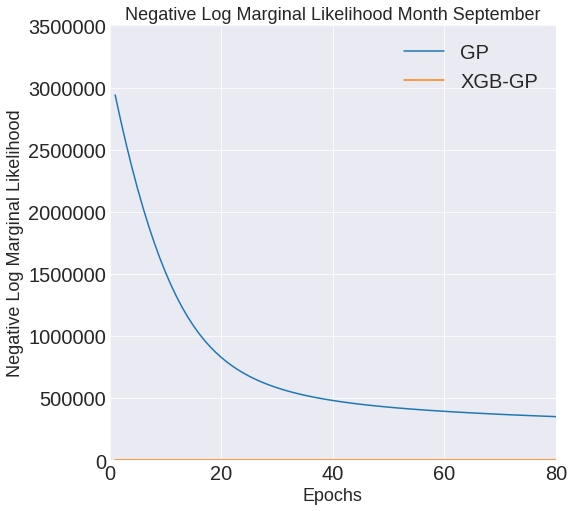

In [0]:
method = "gp"
mll_record = pd.read_csv("/content/drive/My Drive/sweden/mll_{}.csv".format(month))

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 80])
ax.set_ylim([0, 0.35e7])

if method == "gp":
    title = "GP"
if method == "xgb_gp":
    title = "XGB-GP"
if method == "xgb":
    title = "XGB"
plt.plot(mll_record["epochs"], mll_record["simple_gp"], label="GP")
plt.legend(loc='upper right', prop={'size': 20})
plt.plot(mll_record["epochs"], mll_record["xgb_gp"], label="XGB-GP")
plt.legend(loc='upper right', prop={'size': 20})
plt.title("Negative Log Marginal Likelihood Month September", fontsize=18)
plt.ylabel("Negative Log Marginal Likelihood", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/sweden/mll_plot_month_{}_{}.pdf".format(month,method))

In [0]:
mll_record

,Unnamed: 0,epochs,simple_gp,xgb_gp
0,0,1.0,2.940036e+06,1.801210
1,1,2.0,2.734409e+06,1.791917
2,2,3.0,2.540292e+06,1.782317
3,3,4.0,2.358526e+06,1.772399
4,4,5.0,2.189230e+06,1.762158
5,5,6.0,2.032119e+06,1.751587
6,6,7.0,1.886629e+06,1.740680
7,7,8.0,1.752298e+06,1.729430
8,8,9.0,1.628626e+06,1.717831
9,9,10.0,1.515177e+06,1.705874


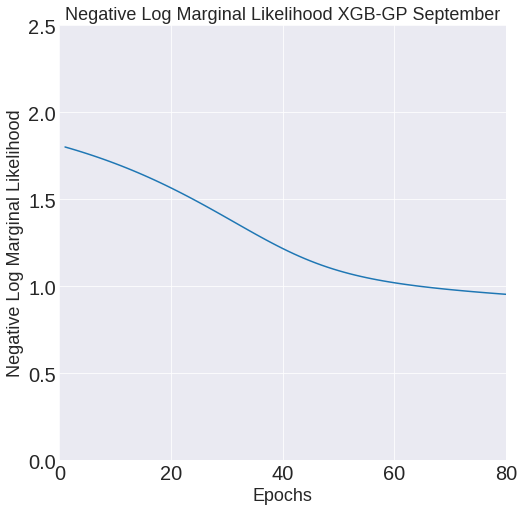

In [0]:
method = "xgb_gp"
mll_record = pd.read_csv("/content/drive/My Drive/sweden/mll_{}.csv".format(month))

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_xlim([0, 80])
ax.set_ylim([0, 2.5])

if method == "gp":
    title = "GP"
if method == "xgb_gp":
    title = "XGB-GP"
if method == "xgb":
    title = "XGB"
plt.plot(mll_record["epochs"], mll_record["xgb_gp"])
plt.title("Negative Log Marginal Likelihood {} September".format(title), fontsize=18)
plt.ylabel("Negative Log Marginal Likelihood", fontsize=18)
plt.xlabel("Epochs", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/sweden/mll_plot_month_{}_{}.pdf".format(month,method))

## Let's make predictions

In [0]:
# make predictions
likelihood = gpytorch.likelihoods.GaussianLikelihood()
x_test_df = data[data["year"]==2017]

for month in range(2,11):

    # subset for month
    x_test = x_test_df[x_test_df["month"] == month]
    test_labels = x_test.loc[:,["name", "year", "month", "yield"]]
    tmp = pd.DataFrame(test_labels)
    x_test = x_test[xgb_variables]

    # linear regression
    data_train = data[(data["month"] == month) & (data["year"] <= 2016)]
    train_x = data_train[xgb_variables]
    train_y = data_train["yield"]
    lm = LinearRegression().fit(train_x, train_y)
    lm_mean = lm.predict(x_test)
    
    # convert to Tensor
    x_test = Tensor(x_test.values)

    # enable cuda
    x_test = x_test.cuda()

    
    likelihood = likelihood.cuda()

    # load up xgb_gp model
    train_x = Tensor(train_x.values).cuda()
    train_y = Tensor(train_y.values).cuda()
    
    xgb_regression = pickle.load(open("/content/drive/My Drive/sweden/xgb_{}.dat".format(month), 'rb'))
    xgb_gp_model = XGBoost_gp(train_x, train_y, likelihood, xgb_regression)
    xgb_gp_model.load_state_dict(torch.load("/content/drive/My Drive/sweden/xgb_gp_{}.pt".format(month)))
    xgb_gp_model = xgb_gp_model.cuda()
    xgb_gp_posterior_pred = predict(x_test, xgb_gp_model, likelihood)
    
    # load up gp model
    gp_model = Simple_GP(train_x, train_y, likelihood)
    gp_model.load_state_dict(torch.load("/content/drive/My Drive/sweden/gp_{}.pt".format(month)))
    gp_model = gp_model.cuda()
    gp_posterior_pred = predict(x_test, gp_model, likelihood)
    
    # pure xgb
    x_pandas = pd.DataFrame(x_test.cpu().numpy(), columns = xgb_variables)
    data_x = xgb.DMatrix(data=x_pandas)
    xgb_pred = xgb_regression.predict(data_x)
    
    # convert posteriors statistics to cpu -> numpy

    tmp["gp_mean"] = gp_posterior_pred.mean.cpu().numpy()
    tmp["gp_sd"] = gp_posterior_pred.stddev.cpu().numpy()
    tmp["xgb_gp_mean"] = xgb_gp_posterior_pred.mean.cpu().numpy()
    tmp["xgb_gp_sd"] = xgb_gp_posterior_pred.stddev.cpu().numpy()
    tmp["xgb"] = xgb_pred
    tmp["lm"] = lm_mean
    
    if month == 2:
        predictions = tmp
    else:
        predictions = pd.concat([predictions,tmp], axis=0)


In [0]:
x_test_df[x_test_df["month"] == 2][xgb_variables]

,longitude,latitude,year,ndvi_mean,gvi_mean,gpp_mean,Minimum_temperature_height_above_ground_6_Hour_Interval_mean,Maximum_temperature_height_above_ground_6_Hour_Interval_mean,Pressure_surface_mean,total_precipitation,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean,prev
180,14.993965,59.371844,2017,0.084267,0.093845,0.000227,271.277679,272.905359,100335.089286,69.220286,0.329041,0.211913,0.284122,4980
381,15.674157,58.368688,2017,0.252354,0.226160,0.000618,272.608043,274.098615,100509.558661,43.539850,0.300536,0.241193,0.265731,5370
582,13.606550,55.962848,2017,0.096322,0.073823,0.000727,274.042826,275.321664,101167.284926,84.928600,0.317469,0.278739,0.306219,5400
785,16.702684,59.093177,2017,0.058364,0.045687,0.000616,271.251479,273.092358,101157.263736,39.688220,0.367125,0.306150,0.382485,4870
988,16.344009,59.818081,2017,0.095697,0.084456,0.000377,271.092037,272.931759,101076.346026,38.483392,0.353361,0.283494,0.352702,4680
1191,12.880139,58.314925,2017,0.251339,0.240134,0.000693,272.525638,273.998087,99776.760204,44.556612,0.292824,0.215794,0.259839,4940


In [0]:
x_test_df[x_test_df["month"] == 3][xgb_variables]

,longitude,latitude,year,ndvi_mean,gvi_mean,gpp_mean,Minimum_temperature_height_above_ground_6_Hour_Interval_mean,Maximum_temperature_height_above_ground_6_Hour_Interval_mean,Pressure_surface_mean,total_precipitation,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_5_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_150_cm_mean,Volumetric_Soil_Moisture_Content_depth_below_surface_layer_25_cm_mean,prev
181,14.993965,59.371844,2017,0.198002,0.184731,0.004509,274.000806,276.637904,99868.225806,64.068387,0.277402,0.246804,0.296017,4980
382,15.674157,58.368688,2017,0.266331,0.240000,0.006362,274.772652,277.358865,100087.304996,38.487407,0.260806,0.251596,0.262179,5370
583,13.606550,55.962848,2017,0.283692,0.266603,0.007254,276.342006,278.301538,100931.671331,60.505804,0.311404,0.309656,0.315596,5400
786,16.702684,59.093177,2017,0.216851,0.195456,0.004900,273.838799,276.632465,100670.301902,47.406051,0.358299,0.319878,0.401086,4870
989,16.344009,59.818081,2017,0.175946,0.175339,0.003791,273.701628,276.529545,100583.774253,47.048427,0.336233,0.292269,0.382213,4680
1192,12.880139,58.314925,2017,0.266951,0.259665,0.005393,274.503917,277.023560,99394.038018,56.446175,0.247915,0.230433,0.250904,4940


In [0]:
xgb_gp_posterior_pred.mean

tensor([4816.8408, 5142.1504, 5389.3062, 4542.5869, 4644.5166, 4573.4399],
       device='cuda:0')

In [0]:
xgb_pred

array([4816.8403, 5142.15  , 5389.306 , 4542.5864, 4644.516 , 4573.439 ],
      dtype=float32)

In [0]:
# load up predictions from BART
bart_predictions = pd.read_csv("/content/drive/My Drive/sweden/prediction_monthly_2017.csv")

In [0]:
bart_predictions = bart_predictions[bart_predictions["crop"] == "spring_barley"]

In [0]:
predictions = pd.merge(predictions, bart_predictions, how="inner", on=["year", "month", "name"])

In [0]:
bart_predictions.head()

,year,month,name,crop,prediction_mean,prediction_lower_95,prediction_upper_95
0,2017,2,Örebro,spring_barley,4289.085357,3401.246181,5160.290471
1,2017,2,Östergötland,spring_barley,4438.728342,3515.045929,5381.626074
2,2017,2,Skåne,spring_barley,5183.619323,4393.446300,5966.067515
3,2017,2,Södermanland,spring_barley,4685.237209,3782.017105,5534.726520
4,2017,2,Västmanland,spring_barley,4399.520072,3572.070458,5205.437627


In [0]:
predictions.rename(columns={'prediction_mean':'bart_mean', 
                            'prediction_lower_95': 'bart_lower',
                            'prediction_upper_95': 'bart_upper'}, inplace=True)

In [0]:
predictions.head()

,name,year,month,yield,gp_mean,gp_sd,xgb_gp_mean,xgb_gp_sd,xgb,lm,crop,bart_mean,bart_lower,bart_upper
0,Örebro,2017,2,5610,4512.230957,1.027336,4909.440430,0.791377,4909.440430,4511.658717,spring_barley,4289.085357,3401.246181,5160.290471
1,Östergötland,2017,2,6140,4503.376953,1.095638,4916.804199,1.044146,4916.804688,4926.368862,spring_barley,4438.728342,3515.045929,5381.626074
2,Skåne,2017,2,6560,4425.691406,1.148220,5427.286621,1.072127,5427.286621,5702.214274,spring_barley,5183.619323,4393.446300,5966.067515
3,Södermanland,2017,2,4870,4041.039062,1.103597,4796.169434,1.048739,4796.169434,5039.462328,spring_barley,4685.237209,3782.017105,5534.726520
4,Västmanland,2017,2,5670,3901.190430,1.104971,4917.657227,1.050219,4917.657715,4671.109433,spring_barley,4399.520072,3572.070458,5205.437627


In [0]:
predictions.to_csv("/content/drive/My Drive/sweden/predictions_2017.csv")

## Let's compute RMSEs

In [0]:
# read from saved predictions
predictions = pd.read_csv("/content/drive/My Drive/sweden/predictions_2017.csv")

In [0]:
predictions

,Unnamed: 0,name,year,month,yield,gp_mean,gp_sd,xgb_gp_mean,xgb_gp_sd,xgb,lm,crop,bart_mean,bart_lower,bart_upper
0,0,Örebro,2017,2,5610,4512.2310,1.027336,4909.4404,0.791377,4909.4404,4511.658717,spring_barley,4289.085357,3401.246181,5160.290471
1,1,Östergötland,2017,2,6140,4503.3770,1.095638,4916.8040,1.044146,4916.8047,4926.368862,spring_barley,4438.728342,3515.045929,5381.626074
2,2,Skåne,2017,2,6560,4425.6914,1.148220,5427.2866,1.072127,5427.2866,5702.214274,spring_barley,5183.619323,4393.446300,5966.067515
3,3,Södermanland,2017,2,4870,4041.0390,1.103597,4796.1694,1.048739,4796.1694,5039.462328,spring_barley,4685.237209,3782.017105,5534.726520
4,4,Västmanland,2017,2,5670,3901.1904,1.104971,4917.6570,1.050219,4917.6577,4671.109433,spring_barley,4399.520072,3572.070458,5205.437627
5,5,Västra Götaland,2017,2,5280,4181.0405,1.133077,4727.0176,1.048359,4727.0186,4861.101869,spring_barley,4413.660660,3572.826249,5297.838895
6,6,Örebro,2017,3,5610,4238.9940,1.103266,4845.1400,0.974773,4845.1416,4765.232002,spring_barley,4270.783289,3533.812287,5105.344843
7,7,Östergötland,2017,3,6140,4468.1260,1.103084,5035.8340,0.915081,5035.8330,5015.154332,spring_barley,4615.711171,3726.837241,5378.865146
8,8,Skåne,2017,3,6560,4412.2446,1.148309,6309.9336,0.978361,6309.9326,5976.064766,spring_barley,5753.004603,4947.248800,6546.101096
9,9,Södermanland,2017,3,4870,3999.5122,1.115824,4738.0720,1.019848,4738.0730,4780.366171,spring_barley,4686.785222,3814.162900,5564.934157


In [0]:
gp_mse = np.sqrt(sum((predictions["yield"].values - predictions["gp_mean"].values)**2) / predictions.shape[0])
xgb_gp_mse = np.sqrt(sum((predictions["yield"].values - predictions["xgb_gp_mean"].values)**2) / predictions.shape[0])
xgb_mse = np.sqrt(sum((predictions["yield"].values - predictions["xgb"].values)**2) / predictions.shape[0])
bart_mse = np.sqrt(sum((predictions["yield"].values - predictions["bart_mean"].values)**2) / predictions.shape[0])
lm_mse = np.sqrt(sum((predictions["yield"].values - predictions["lm"].values)**2) / predictions.shape[0])

print("GP MSE:{}".format(gp_mse))
print("XGB-GP MSE:{}".format(xgb_gp_mse))
print("XGB MSE:{}".format(xgb_mse))
print("BART MSE:{}".format(bart_mse))
print("LM MSE:{}".format(lm_mse))

GP MSE:1520.214764084261
XGB-GP MSE:785.488746659742
XGB MSE:785.4889788834178
BART MSE:971.9286725039965
LM MSE:785.6927231768473


In [0]:
# MAPE
gp_mape = sum(np.abs(predictions["yield"].values - predictions["gp_mean"].values) / predictions["yield"].values) / predictions.shape[0] * 100
xgb_gp_mape = sum(np.abs(predictions["yield"].values - predictions["xgb_gp_mean"].values) / predictions["yield"].values) / predictions.shape[0] * 100
xgb_mape = sum(np.abs(predictions["yield"].values - predictions["xgb"].values) / predictions["yield"].values) / predictions.shape[0] * 100
bart_mape = sum(np.abs(predictions["yield"].values - predictions["bart_mean"].values) / predictions["yield"].values) / predictions.shape[0] * 100
lm_mape = sum(np.abs(predictions["yield"].values - predictions["lm"].values) / predictions["yield"].values) / predictions.shape[0] * 100

print("GP MAPE:{}".format(gp_mape))
print("XGB-GP MAPE:{}".format(xgb_gp_mape))
print("XGB MAPE:{}".format(xgb_mape))
print("BART MAPE:{}".format(bart_mape))
print("LM MAPE:{}".format(lm_mape))

GP MAPE:25.17492239138367
XGB-GP MAPE:12.151831184312352
XGB MAPE:12.151835756848863
BART MAPE:15.11278397721583
LM MAPE:11.832654444049043


## Let's plot the YY plot


In [0]:
def plot_yy(predictions, method):
    """plots cropyield: observed vs predicted
    
    """
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    mean = predictions["{}_mean".format(method)]
    lower = mean - 1.96*predictions["{}_sd".format(method)]
    upper = mean + 1.96*predictions["{}_sd".format(method)]
    ax.errorbar(predictions["yield"], mean,
                yerr=[1.96*predictions["{}_sd".format(method)], 1.96*predictions["{}_sd".format(method)]],
                fmt='o', ls='none', capsize=5, markersize=4, color = "blue")
    #ax.scatter(predictions["Crop_Yield"], mean, marker=".")
    lims = [
        np.min([50, 50]),  # min of both axes
        np.max([8000, 8000]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    if method == "gp":
        title = "GP"
    if method == "xgb_gp":
        title = "XGB-GP"
    if method == "xgb":
        title = "XGB"
    
    plt.title("Crop Yield vs {} Prediction 2017".format(title), fontsize=18)
    plt.xlabel("Observed Crop Yield kg/hectare", fontsize=18)
    plt.ylabel("Predicted Crop Yield kg/hectare", fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.show()
    f.savefig("/content/drive/My Drive/sweden/yy_plot_2017_2018_{}.pdf".format(method))

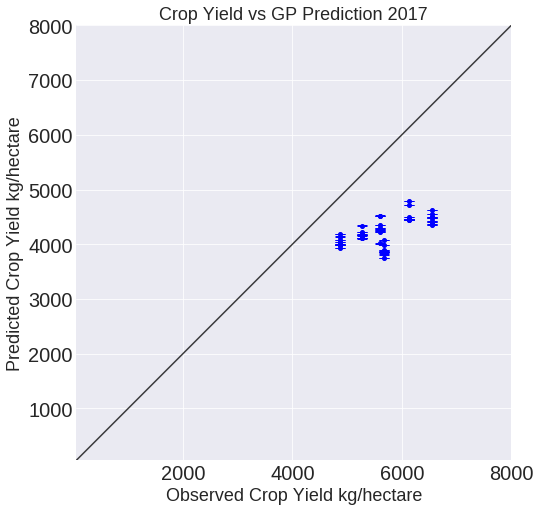

In [0]:
plot_yy(predictions, "gp")

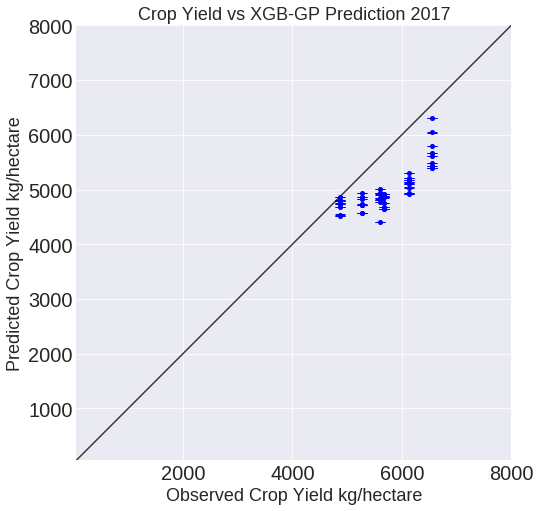

In [0]:
plot_yy(predictions, "xgb_gp")

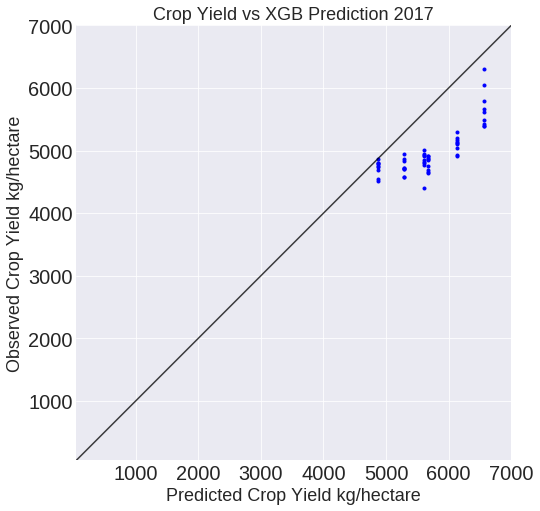

In [0]:
method="xgb"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["{}".format(method)]
ax.scatter(predictions["yield"], mean, marker=".", color = "blue")

lims = [
    np.min([50, 50]),  # min of both axes
    np.max([7000, 7000]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

title = "XGB"
plt.title("Crop Yield vs {} Prediction 2017".format(title), fontsize=18)
plt.ylabel("Observed Crop Yield kg/hectare", fontsize=18)
plt.xlabel("Predicted Crop Yield kg/hectare", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/sweden/yy_plot_2017_2018_{}.pdf".format(method))

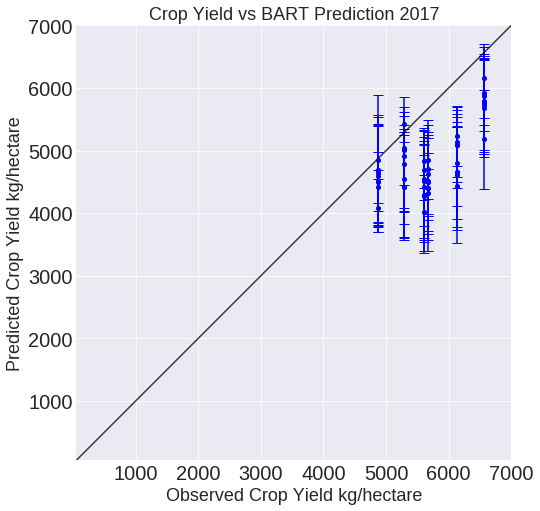

In [0]:
method = "bart"
title = "BART"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["{}_mean".format(method)]
lower = mean - predictions["bart_lower"]
upper = predictions["bart_upper"] - mean
ax.errorbar(predictions["yield"], mean,
            yerr=[lower, upper],
            fmt='o', ls='none', capsize=5, markersize=4, color = "blue")
#ax.scatter(predictions["Crop_Yield"], mean, marker=".")
lims = [
    np.min([50, 50]),  # min of both axes
    np.max([7000, 7000]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title("Crop Yield vs {} Prediction 2017".format(title), fontsize=18)
plt.xlabel("Observed Crop Yield kg/hectare", fontsize=18)
plt.ylabel("Predicted Crop Yield kg/hectare", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/sweden/yy_plot_2017_2018_{}.pdf".format(method))

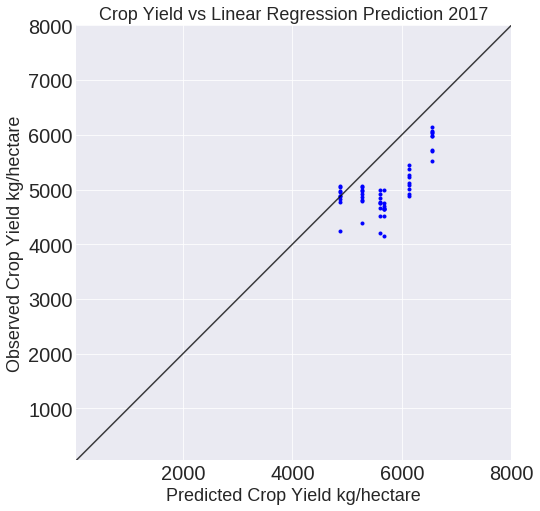

In [0]:
method = "lm"
title = "Linear Regression"
f, ax = plt.subplots(1, 1, figsize=(8, 8))
mean = predictions["lm"]
ax.scatter(predictions["yield"], mean, marker=".", color = "blue")

lims = [
    np.min([50, 50]),  # min of both axes
    np.max([8000, 8000]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.title("Crop Yield vs {} Prediction 2017".format(title), fontsize=18)
plt.ylabel("Observed Crop Yield kg/hectare", fontsize=18)
plt.xlabel("Predicted Crop Yield kg/hectare", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.show()
f.savefig("/content/drive/My Drive/sweden/yy_plot_2017_2018_{}.pdf".format(method))

## Let's generate state-wise plots

In [0]:
def plot_state(predictions):    
    """plot state-wise predictions
    """
    f, ax = plt.subplots(2, 3, figsize=(18, 18))

    plot_num = 0
    
    for province in set(predictions.name):
        
        state_df = predictions[predictions["name"]==province]
        district_df = state_df.sort_values(by=['year', "month"])
        district_yield = district_df["yield"]
        district_predictions_gp = district_df["gp_mean"]
        district_predictions_xgb_gp = district_df["xgb_gp_mean"]
        district_predictions_xgb = district_df["xgb"]
        district_predictions_bart = district_df["bart_mean"]
        district_predictions_lm = district_df["lm"]

        district_df['date'] = district_df['month'].map(str)+ '-' +district_df['year'].map(str)
        district_df['date'] = pd.to_datetime(district_df['date'], format='%m-%Y').dt.strftime('%m-%Y')

        plt.subplot(331 + plot_num)
        plt.xticks(rotation=70)
        plt.ylim(50,8000)

        plt.plot(district_df['date'], district_yield, label="Actual")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_xgb_gp, label="Predicted XGB-GP")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_gp, label="Predicted GP")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_xgb, label="Predicted XGB")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_bart, label="Predicted BART")
        plt.legend(loc='lower left')
        plt.plot(district_df['date'], district_predictions_lm, label="Predicted LM")
        plt.legend(loc='lower left')
        plt.title("{} 2017".format(province))
        plt.ylabel("Crop Yield kg/hectare")
        plot_num += 1
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        
    plt.show()
    f.savefig("/content/drive/My Drive/sweden/2017.png")

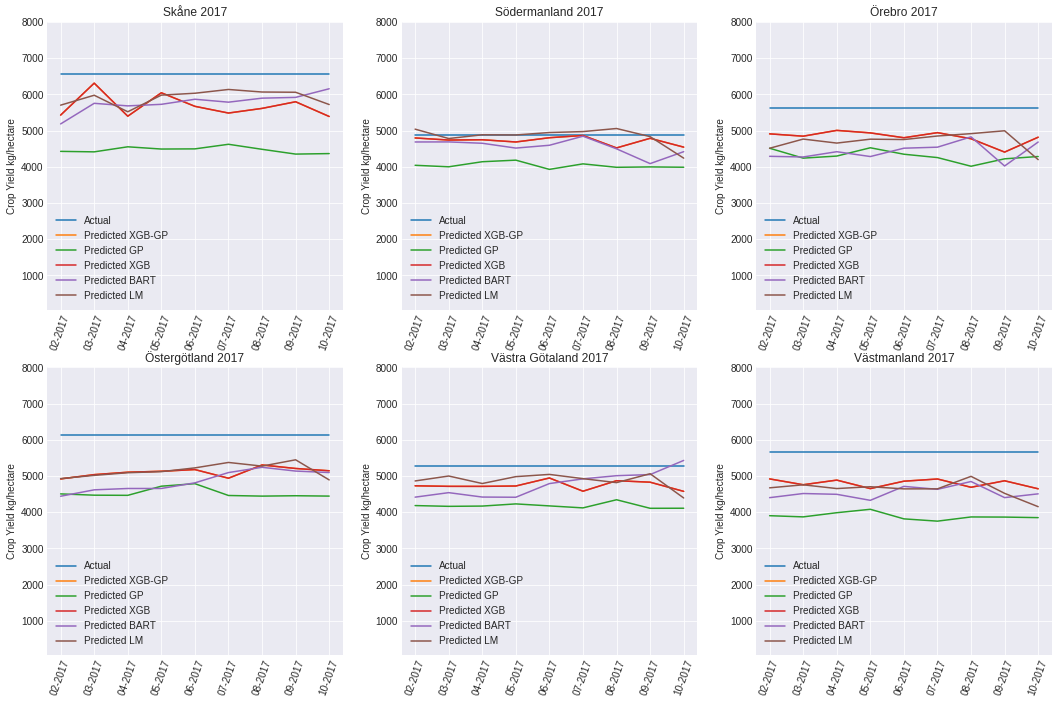

In [0]:
plot_state(predictions)